In [101]:
import gym
import sys
import linearstochlearnerdynamics
import numpy as np
from matplotlib import pyplot as plt

In [106]:
def getOptWeights(m, rewards, pos_weights, alpha):
    maxsofar = -sys.maxsize
    policyvals = dict()
    
    for i, j, w in pos_weights:
        
        a = np.array([
            [alpha*m[0][i][0]-1, alpha*m[0][i][1]],
            [alpha*m[1][j][0], alpha*m[1][j][1]-1]
        ])
        
        b = np.array([
            -(m[0][i][0]*rewards[0][0]+m[0][i][1]*rewards[0][1]),
            -(m[1][j][0]*rewards[1][0]+m[1][j][1]*rewards[1][1])
        ])
        
        v = np.linalg.solve(a, b)
        policyvals[(i,j)] = sum(v * getStatProb((i,j), m))
        
        if sum(v * getStatProb((i,j), m)) > maxsofar:
            maxsofar = sum(v * getStatProb((i,j), m))
            bestpolicy = (i, j, w)
            
    return bestpolicy, policyvals

def getStatProb(policy, trans_matrix):
    a = np.array([
        [trans_matrix[0][policy[0]][0]-1, trans_matrix[1][policy[1]][0]],
        [1,1]
    ])
    b = np.array([0, 1])
    return np.linalg.solve(a, b)

### Toy Problem 1 - Random

[2017-12-04 22:03:04,870] Making new env: ToyProblem1-Random-v0
[2017-12-04 22:03:04,881] Making new env: ToyProblem1-Random-v0


(0, 0, array([-6.22092619]))
[-0.34726868]
0 1


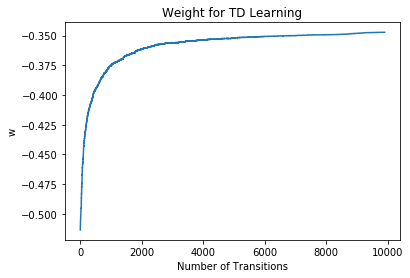

[2017-12-04 22:03:10,487] Making new env: ToyProblem1-Random-v0



[-0.81275953]
0 1


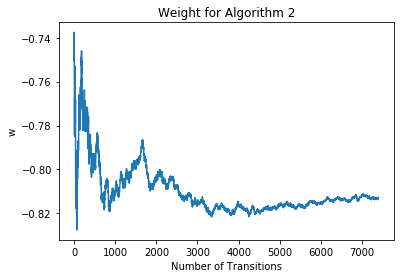

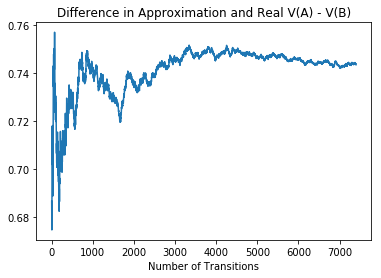

Optimal policy expressible by weights


In [113]:
# Set random feature vector with each uniform [0, 1]
feat = np.random.rand(2,1)*2

# Set random discount alpha
alpha_rand = np.random.rand(1)[0]

# Set up dummy environment 
dummy = linearstochlearnerdynamics.linearStochLearner(feat, 'TD', 'ToyProblem1-Random-v0', alpha = alpha_rand)

## Get trans_matrix and reward function from environment
trans_matrix = dummy.env.unwrapped.trans_matrix
rewards = dummy.env.unwrapped.rewards

## Get critical points
wA = (rewards[0][0] - rewards[0][1]) / (alpha_rand * (feat[1] - feat[0]))
wB = (rewards[1][0] - rewards[1][1]) / (alpha_rand * (feat[1] - feat[0]))

# Remove unattainable policy
if wA < wB:
    dummy.w = wA - 1
    i = dummy.getAction(0)
    dummy.w = wB + 1
    j = dummy.getAction(1)
    pos_weights = [(i, 1-j, wA - 1), (1-i, 1-j, (wA + wB) / 2.0), (1-i, j, wB + 1)]
else:
    dummy.w = wA + 1
    i = dummy.getAction(0)
    dummy.w = wB - 1
    j = dummy.getAction(1)
    pos_weights = [(i, 1-j, wA + 1), (1-i, 1-j, (wA + wB) / 2.0), (1-i, j, wB - 1)]

# Get optimal policy for weights
opt_policy_weights, policyvals = getOptWeights(trans_matrix, rewards, pos_weights, alpha_rand)
print(opt_policy_weights)
opt_weights = opt_policy_weights[2]


all_weights = [(0,0,0),(0,1,0),(1,0,0),(1,1,0)]
optimal_policy, _ = getOptWeights(trans_matrix, rewards, all_weights, alpha_rand)

########## TD
## Set up environment for TD
td=linearstochlearnerdynamics.linearStochLearner(feat, 'TD', 'ToyProblem1-Random-v0', alpha = alpha_rand)

## Copy trans_matrix and reward function to environment
td.env.unwrapped.trans_matrix = trans_matrix
td.env.unwrapped.rewards = rewards

## Set weight with best policy
td.w = opt_weights.copy()

## Solve TD and print new weights
td.policyIterate(num_iter=1, num_ep=100)
print(td.w)

## Get action at each state
print(td.getAction(0), td.getAction(1))
plt.plot(td.weights[100:])
plt.xlabel("Number of Transitions")
plt.ylabel("w")
plt.title("Weight for TD Learning")
plt.show()
print()

########## STD
## Set up environment for STD
std=linearstochlearnerdynamics.linearStochLearner(feat, 'STD-01', 'ToyProblem1-Random-v0', alpha = alpha_rand)

## Copy trans_matrix and reward function to environment
std.env.unwrapped.trans_matrix = trans_matrix
std.env.unwrapped.rewards = rewards

## Set weight with best policy
std.w = opt_weights

## Solve STD and print new weights
std.policyIterate(num_iter=1, num_ep=75)
print(std.w)

## Get action at each state
print(std.getAction(0), std.getAction(1))
plt.plot(std.weights[100:])
plt.xlabel("Number of Transitions")
plt.ylabel("w")
plt.title("Weight for Algorithm 2")
plt.show()
print()

stdAB = (std.weights@np.transpose(feat)-policyvals[(opt_policy_weights[0],opt_policy_weights[1])])@np.transpose(np.array([1,-1]))
plt.plot(stdAB[100:])
plt.xlabel("Number of Transitions")
plt.title("Difference in Approximation and Real V(A) - V(B)")
plt.show()

if td.getAction(0) == opt_policy_weights[0] and td.getAction(1) == opt_policy_weights[1]:
    print("TD gets best available")
        
if std.getAction(0) == opt_policy_weights[0] and std.getAction(1) == opt_policy_weights[1]:
    print("STD gets best available")
    
if opt_policy_weights[0] != optimal_policy[0] or opt_policy_weights[1] != optimal_policy[1]:
    print("Optimal policy not expressible by weights")
else:
    print("Optimal policy expressible by weights")

In [111]:
resultsvec = []
ctr_td = 0
ctr_std = 0
n = 50
for _ in range(n):
    # Set random feature vector with each uniform [0, 2]
    feat = np.random.rand(2,1)*2

    # Set random discount alpha
    alpha_rand = np.random.rand(1)[0]

    # Set up dummy environment 
    dummy = linearstochlearnerdynamics.linearStochLearner(feat, 'TD', 'ToyProblem1-Random-v0', alpha = alpha_rand)

    ## Get trans_matrix and reward function from environment
    trans_matrix = dummy.env.unwrapped.trans_matrix
    rewards = dummy.env.unwrapped.rewards

    ## Get critical points
    wA = (rewards[0][0] - rewards[0][1]) / (alpha_rand * (feat[1] - feat[0]))
    wB = (rewards[1][0] - rewards[1][1]) / (alpha_rand * (feat[1] - feat[0]))

    # Remove unattainable policy
    if wA < wB:
        dummy.w = wA - 1
        i = dummy.getAction(0)
        dummy.w = wB + 1
        j = dummy.getAction(1)
        pos_weights = [(i, 1-j, wA - 1), (1-i, 1-j, (wA + wB) / 2.0), (1-i, j, wB + 1)]
    else:
        dummy.w = wA + 1
        i = dummy.getAction(0)
        dummy.w = wB - 1
        j = dummy.getAction(1)
        pos_weights = [(i, 1-j, wA + 1), (1-i, 1-j, (wA + wB) / 2.0), (1-i, j, wB - 1)]

    # Get optimal policy for weights
    opt_policy_weights, _ = getOptWeights(trans_matrix, rewards, pos_weights, alpha_rand)
    opt_weights = opt_policy_weights[2]

    ########## TD
    ## Set up environment for TD
    td=linearstochlearnerdynamics.linearStochLearner(feat, 'TD', 'ToyProblem1-Random-v0', alpha = alpha_rand)

    ## Copy trans_matrix and reward function to environment
    td.env.unwrapped.trans_matrix = trans_matrix
    td.env.unwrapped.rewards = rewards

    ## Set weight with best policy
    td.w = opt_weights.copy()

    ## Solve TD and print new weights
    td.policyIterate(num_iter=1, num_ep=50)


    ########## STD
    ## Set up environment for STD
    std=linearstochlearnerdynamics.linearStochLearner(feat, 'STD-01', 'ToyProblem1-Random-v0', alpha = alpha_rand)

    ## Copy trans_matrix and reward function to environment
    std.env.unwrapped.trans_matrix = trans_matrix
    std.env.unwrapped.rewards = rewards

    ## Set weight with best policy
    std.w = opt_weights

    ## Solve STD and print new weights
    std.policyIterate(num_iter=1, num_ep=50)

    if td.getAction(0) == opt_policy_weights[0] and td.getAction(1) == opt_policy_weights[1]:
        resultsvec.append([1])
    else:
        resultsvec.append([0])
        
    if std.getAction(0) == opt_policy_weights[0] and std.getAction(1) == opt_policy_weights[1]:
        resultsvec[-1].append(1)
    else:
        resultsvec[-1].append(0)

    if opt_policy_weights[0] != optimal_policy[0] or opt_policy_weights[1] != optimal_policy[1]:
        resultsvec[-1].append(0)
    else:
        resultsvec[-1].append(1)
    
print(np.array(resultsvec))

[2017-12-04 22:00:03,740] Making new env: ToyProblem1-Random-v0
[2017-12-04 22:00:03,749] Making new env: ToyProblem1-Random-v0
[2017-12-04 22:00:06,429] Making new env: ToyProblem1-Random-v0
[2017-12-04 22:00:07,908] Making new env: ToyProblem1-Random-v0
[2017-12-04 22:00:07,916] Making new env: ToyProblem1-Random-v0
[2017-12-04 22:00:10,491] Making new env: ToyProblem1-Random-v0
[2017-12-04 22:00:11,880] Making new env: ToyProblem1-Random-v0
[2017-12-04 22:00:11,890] Making new env: ToyProblem1-Random-v0
[2017-12-04 22:00:14,690] Making new env: ToyProblem1-Random-v0
[2017-12-04 22:00:16,220] Making new env: ToyProblem1-Random-v0
[2017-12-04 22:00:16,229] Making new env: ToyProblem1-Random-v0
[2017-12-04 22:00:19,207] Making new env: ToyProblem1-Random-v0
[2017-12-04 22:00:20,569] Making new env: ToyProblem1-Random-v0
[2017-12-04 22:00:20,577] Making new env: ToyProblem1-Random-v0
[2017-12-04 22:00:23,142] Making new env: ToyProblem1-Random-v0
[2017-12-04 22:00:24,521] Making new env

[[0 1 0]
 [0 1 1]
 [0 1 1]
 [0 1 1]
 [1 1 0]
 [0 0 1]
 [1 1 0]
 [1 1 0]
 [1 1 0]
 [1 1 1]]


In [112]:
a = np.array(resultsvec)
print(sum(a[:,0]), sum(a[:,1]), sum(a[:,2]))

5 9 5
